In [1]:
'''
    Setting up path configurations
'''
import sys, os
import yaml

stream = open('../trojai_rl/subspace_sanitize/params.yml', 'r')
mydict = yaml.full_load(stream)

project_dir_path = os.path.abspath('../')
output_dir_path = os.path.join(project_dir_path, 'outputs/')
big_data_dir_path = mydict['big_data_dir_path']

# add root path to the execution environment
sys.path.append(project_dir_path)

In [2]:
import numpy as np
from tqdm import tqdm
import random, copy
import pandas as pd
import torch, torch_ac
from ast import literal_eval
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from collections import deque

## load data

### set seed = 22

In [4]:
# set seeds
set_seed = True
this_seed = 22
torch.manual_seed(this_seed)
random.seed(this_seed)
np.random.seed(this_seed)

In [5]:
clean_samples_dir_path = os.path.join(big_data_dir_path,'poison_100th_byte_trigger_magnitude_255')

df_samples = pd.DataFrame()
for i in range(1,2,1):
    
    file_name = 'seed_'+str(i)+'_numEpisodes_100.csv'

    file_path = os.path.join(clean_samples_dir_path, file_name)
    df_data = pd.read_csv(file_path)
    df_data = df_data.loc[:, ~df_data.columns.str.contains('^Unnamed')]
    df_data['obs'] = df_data['obs'].apply(literal_eval)
    
    # sample one uniformly random time step from each episode
    size = 1        # sample size
    replace = True  # with replacement
    random_sampler = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
    df_samples_i = df_data.groupby('episode', as_index=False).apply(random_sampler)
    
    if(i==1):
        df_samples = df_samples_i
    else:
        df_samples = pd.concat([df_samples, df_samples_i],ignore_index=True)
    
display(df_samples)

,,seed,episode,time,obs,action,reward,done,other
0,885,1,0,885,"[21.0, 64.0, 64.0, 67.0, 96.0, 82.0, 85.0, 0.0...",8,0,False,none
1,4009,1,1,2180,"[17.0, 116.0, 113.0, 66.0, 52.0, 71.0, 87.0, 0...",13,0,False,none
2,5024,1,2,812,"[25.0, 54.0, 50.0, 88.0, 108.0, 44.0, 45.0, 0....",2,0,False,none
3,6439,1,3,356,"[66.0, 24.0, 19.0, 60.0, 88.0, 37.0, 47.0, 0.0...",16,0,False,none
4,9660,1,4,1382,"[80.0, 83.0, 56.0, 87.0, 106.0, 38.0, 42.0, 0....",2,0,False,none
...,...,...,...,...,...,...,...,...,...
95,188402,1,95,914,"[20.0, 65.0, 65.0, 73.0, 87.0, 35.0, 32.0, 0.0...",2,0,False,none
96,189891,1,96,729,"[35.0, 48.0, 17.0, 71.0, 85.0, 36.0, 37.0, 0.0...",2,0,False,none
97,192484,1,97,1129,"[4.0, 73.0, 82.0, 71.0, 98.0, 53.0, 64.0, 0.0,...",16,0,False,none
98,193224,1,98,96,"[85.0, 9.0, 2.0, 62.0, 76.0, 43.0, 44.0, 0.0, ...",14,0,False,none


In [6]:
obs_matrix = np.vstack(df_samples['obs']).T
print(obs_matrix.shape)

(32, 100)


### finding the singular value spectrum and performance data

In [7]:
ls, sv, rs = np.linalg.svd(obs_matrix[:, 0:40])

In [8]:
input_dir = os.path.join(output_dir_path, 'TROJ-22')

In [9]:
dimension_list =  os.listdir(input_dir)
dimension_list.remove('code')
dimension_list.remove('samples.csv')

In [10]:

empirical_value_mean_list, empirical_value_std_list = [], []
for dimension in dimension_list:
    
    empirical_value_list = []
    for repeat_id in range(4):
        result_file = os.path.join(input_dir, dimension, 'reapeat_'+str(repeat_id), 'results_df.csv')
        df = pd.read_csv(result_file)
        empirical_value = np.mean(df.groupby(['episode'])['reward'].sum())
        empirical_value_list.append(empirical_value)
    empirical_value_mean_list.append(np.mean(empirical_value_list))
    empirical_value_std_list.append(np.std(empirical_value_list))    

## Generate the plot

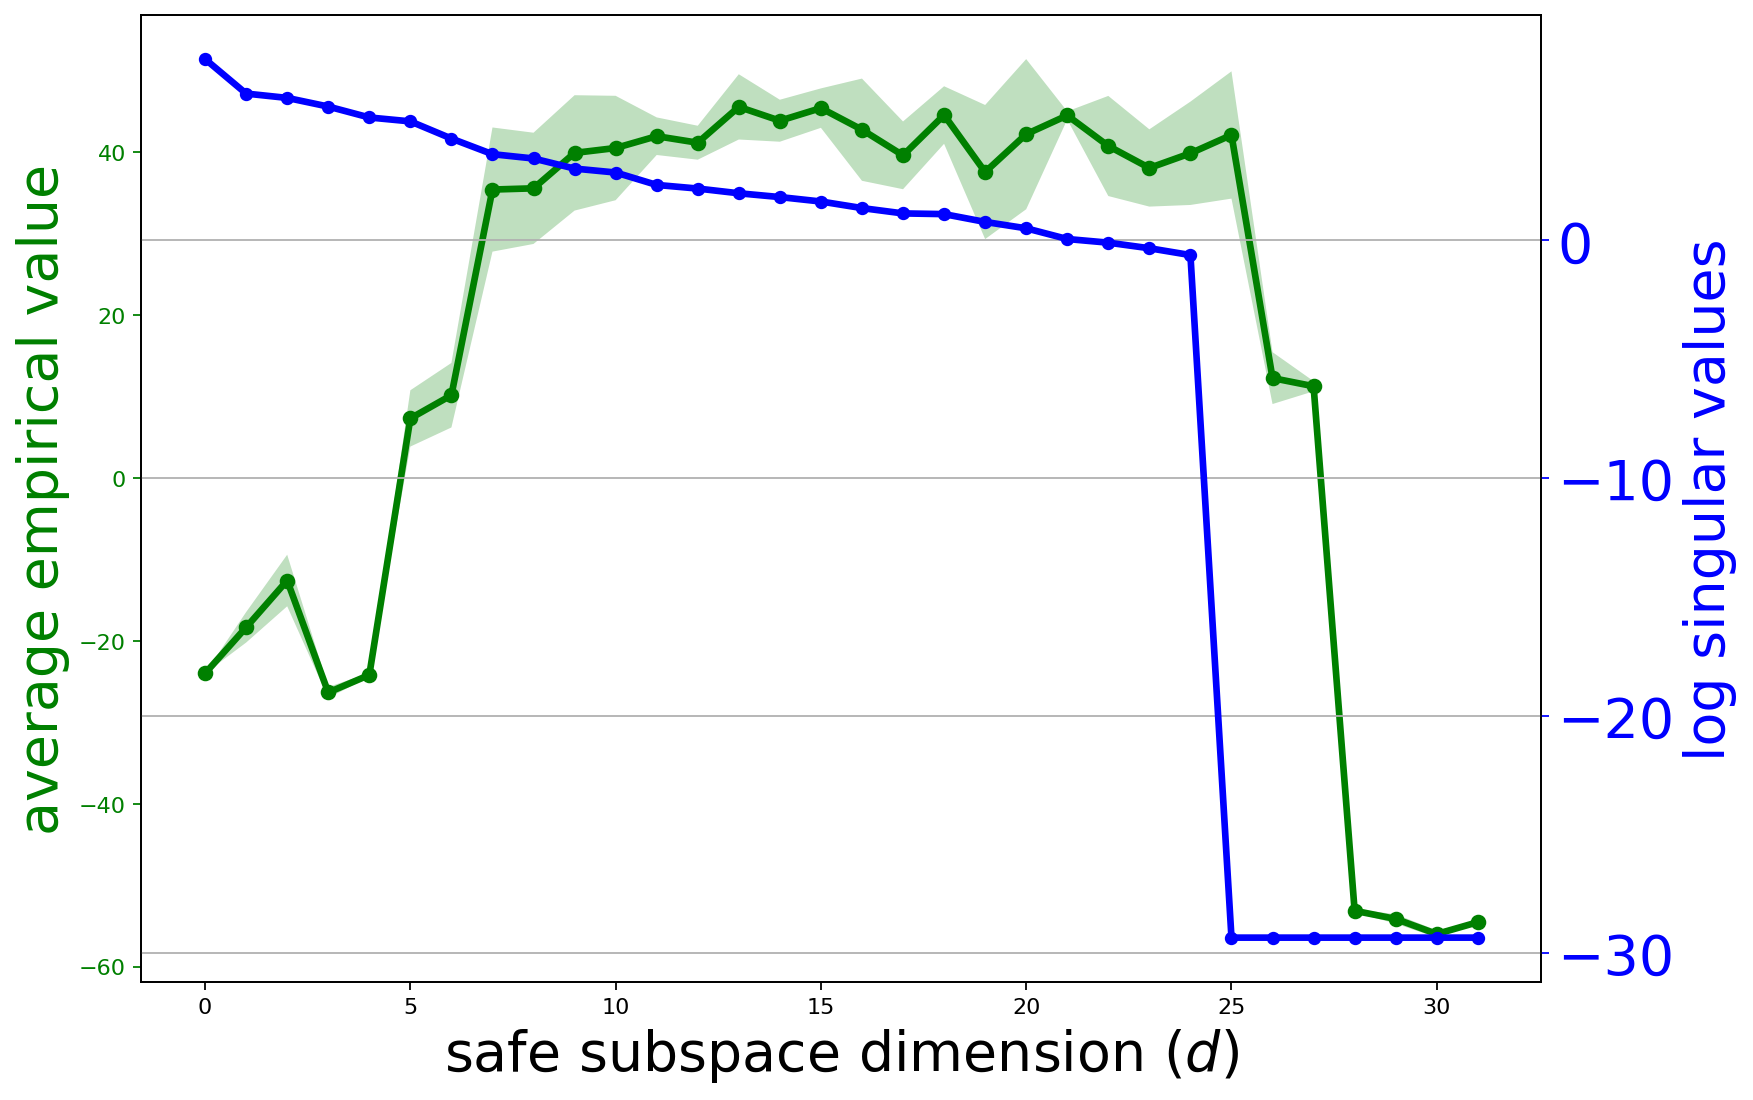

In [11]:
# To make things reproducible...
np.random.seed(1977)

x_range = np.arange(len(empirical_value_mean_list))
empirical_value_mean_list, empirical_value_std_list = np.array(empirical_value_mean_list), np.array(empirical_value_std_list) 

fig, ax = plt.subplots(figsize=(14,8), dpi=160)
plt.rcParams['font.size'] = '25'

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)


# To make the border of the right-most axis visible, we need to turn the frame
# on. This hides the other plots, however, so we need to turn its fill off.
axes[-1].set_frame_on(True)
axes[-1].patch.set_visible(False)

# And finally we get to plot things...
colors = ('Green', 'blue')

ax, color = axes[0], colors[0]
ax.plot(x_range, empirical_value_mean_list, marker='.', linestyle='-', markersize=12, linewidth=3, color=color)

ax.fill_between(x_range, empirical_value_mean_list-empirical_value_std_list, empirical_value_mean_list+empirical_value_std_list, facecolor='green', alpha=0.25, label='sanitized in trigger env')

ax.set_ylabel('average empirical value', color=color, fontsize=25)
ax.tick_params(axis='y', colors=color)

ax, color = axes[1], colors[1]
ax.plot(np.log(sv), marker='.', linestyle='-', markersize=10, linewidth=3, color=color)
ax.set_ylabel('log singular values', color=color, fontsize=25)
ax.tick_params(axis='y', colors=color)

axes[0].set_xlabel('safe subspace dimension $(d)$', fontsize=25)

plt.grid()
plt.savefig('spectrum_safe_subspace_boxing.pdf')
plt.show()